[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/14thApostle/ME6324-Steel-Defect-segmentation/blob/main/starter_test1.ipynb)

In [34]:
# library imports
import random

import os
import cv2
import pdb
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt


# for reproducibility
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

import os
from os.path import join
import sys
import skimage.io
from pathlib import Path

!pip install plotly

# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# paths
root_dir = './severstal-steel-defect-detection/'
img_train_folder = Path(join(root_dir, 'train_images/'))
img_test_folder = Path(join(root_dir,'test_images/'))

""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

## Loss Function

### Dice Coefficient

Inorder to evaluate how close our predictions are to being true, we employ the Dice coefficient.
$$Dice(X,Y) = \frac{2∗|X∩Y|}{|X|+|Y|}$$

Visual illustration:
![dice_viz](https://i.imgur.com/zl2W0xQ.png)

In [2]:
def dice_coefficient(X, y):
    # X and y are matrices of which the overlap of 1's is evaluated 
    # convert the pixel/mask matrix to a one-dimensional series
    predicted = X.flatten()
    truth = y.flatten()
    
    # our masks will consist of ones and zeros
    # summing the result of their product gives us the cross section
    overlap = np.sum(predicted * truth)
    total_surface_area = np.sum(predicted + truth)
    
    # passing our calculated values to the formula
    return 2 * overlap / total_surface_area

### Mean Dice Coefficient
The dataset's original format (one row per *imageId:classId* pair) points at the fact that we will have to run this dice coefficient function over every layer in our mask and take the average. If we train multiple images at a time, we will have to take the average across a batch.

## Run-Length Encoding

Inorder to reduce the mask file size, our metric uses run-length encoding on the pixel values. Instead of an exhaustive list of indices for our segmentation, there will be **pairs of values** that contain a **start position and a run length**

In [3]:
def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indeces where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [4]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

<a id="2"></a> <br>
# Exploratory Data Analysis

## Class Imbalances
A huge imbalance quickly becomes apparent when looking at the training set description:

![class_imbalance](https://i.imgur.com/B4Dsxur.png)

Only 7095 pictures will be of any use to us when training since only those images are defective.


In [33]:
baseline_score = ( 1 * (50272-7094) + 0 * 7094 ) / 50272
baseline_score

0.8588876511775939

## Baseline
If we'd train on the entire dataset, the risk is substantial that our model will simply learn the **majority class** (no defect, ever).
Indeed, if we simply make a model that predicts all images to be non-defective, it gives us the following accuracy:

![baseline_score](https://i.imgur.com/AXaygTV.png)

This is the benchmark to beat. 

## Class Imbalances (continued)
Let's see how often each class appears, as well as how the class distribution is inside images.

In [10]:
# reading in the training set
data = pd.read_csv(join(root_dir,'train.csv'))
data['ClassId'] = data['ClassId'].astype(np.uint8)

# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = (
    data[['ImageId', 'EncodedPixels', 'ClassId']]
        .groupby('ImageId', as_index=False) 
        .agg(list) 
)

# count the amount of class labels per image
squashed['DistinctDefectTypes'] = squashed['ClassId'].apply(lambda x: len(x))

# display first ten to show new structure
squashed.head(10)

,ImageId,EncodedPixels,ClassId,DistinctDefectTypes
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
5,0025bde0c.jpg,[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...,"[3, 4]",2
6,002af848d.jpg,[290800 6 291055 13 291311 15 291566 18 291822...,[4],1
7,002fc4e19.jpg,[146021 3 146275 10 146529 40 146783 46 147038...,"[1, 2]",2
8,0030401a5.jpg,[186833 1 187089 3 187344 6 187600 7 187855 10...,[4],1
9,0046839bd.jpg,[152926 1 153180 4 153434 6 153689 8 153943 11...,[3],1


In [8]:
# we want counts & frequency of the labels
classes = (
    data.groupby(by='ClassId', as_index=False)
        .agg({'ImageId':'count'})
        .rename(columns={'ImageId':'Count'})
)

classes['Frequency'] = round(classes['Count'] / classes['Count'].sum() * 100, 2) 
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=classes.Count,
        y=classes.ClassId,
        hovertext=classes.Frequency,
        text=classes.Count,
        textposition='auto',
        marker_color=colors),
    
    layout=go.Layout(
        title='Defect Type: Count & Frequency',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=400
    )
)

# display
fig.show()

An overwhelming amount of the observations is for class 3.

Let's see what the distributions are if we consider all possible combinations, including multi-class instances.

In [12]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

<a id="3"></a> <br>
# Data Shapes

## Images
The input shape will be an image we convert to a three-dimensional array with shape ```(256, 1600, 3)```, for height, width, and the three colour channels (RGB), respectively.
![label shape](https://imgur.com/uiiyoqN.jpg)


## Masks
Naturally, the masks will share the same width and height, but the third dimension will be as large as there are labels ```(256, 1600, 4)```, with each class occupying a different layer. Somewhat like this:
![label shape](https://i.imgur.com/PePSemo.png)

## Batch Size

BATCH_SIZE = 16

To leverage the parellel computation a GPU offers, we will feed the images and their labels to the algorithm in batches. Consequently, our array dimensions will be expanded to ```(batch size, 256, 1600, 3)``` and ```(batch size, 256, 1600, 4)```, respectively.

<a id="4"></a> <br>
# Visualising the Masks

In [15]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """
    contours, _ = cv2.findContours(mask_layer, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(image, contours, -1, color, 2)
        
    return image

def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv2.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        # indices are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

## Expected outputs

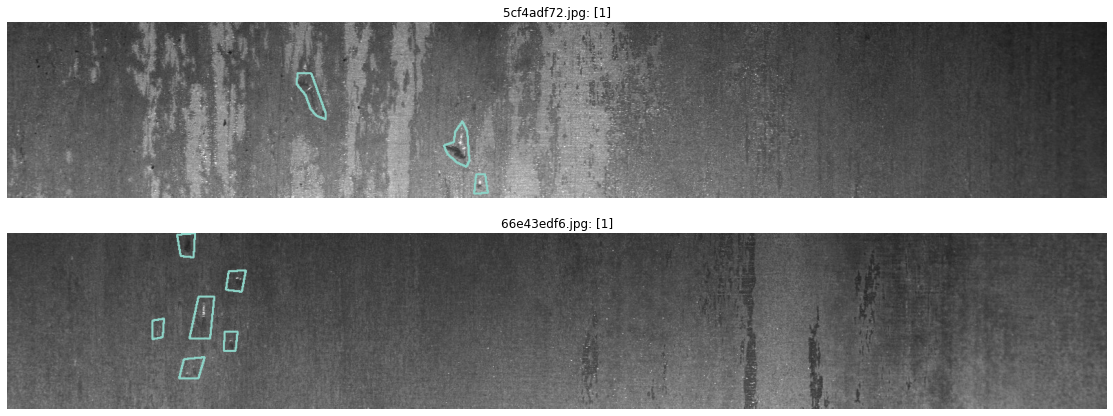

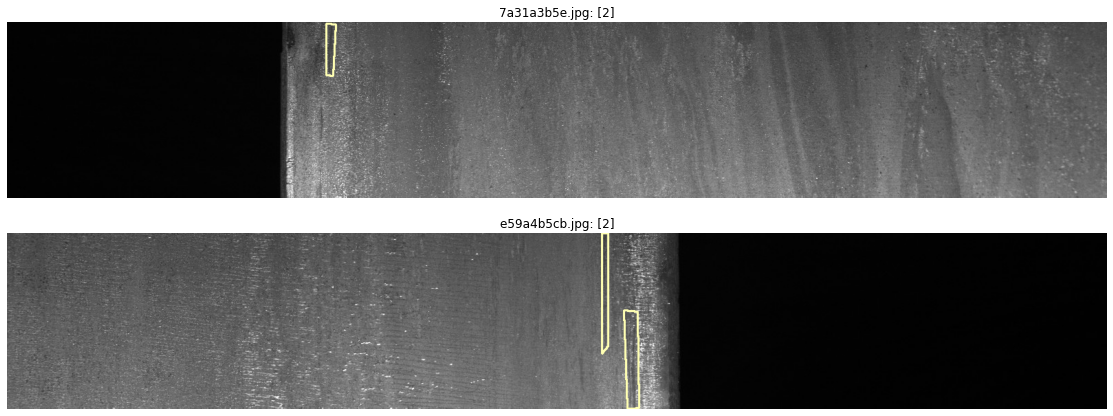

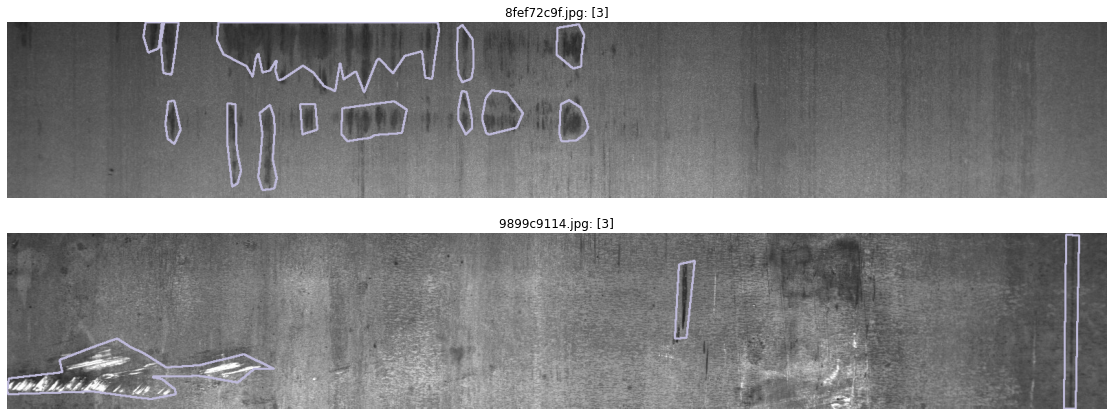

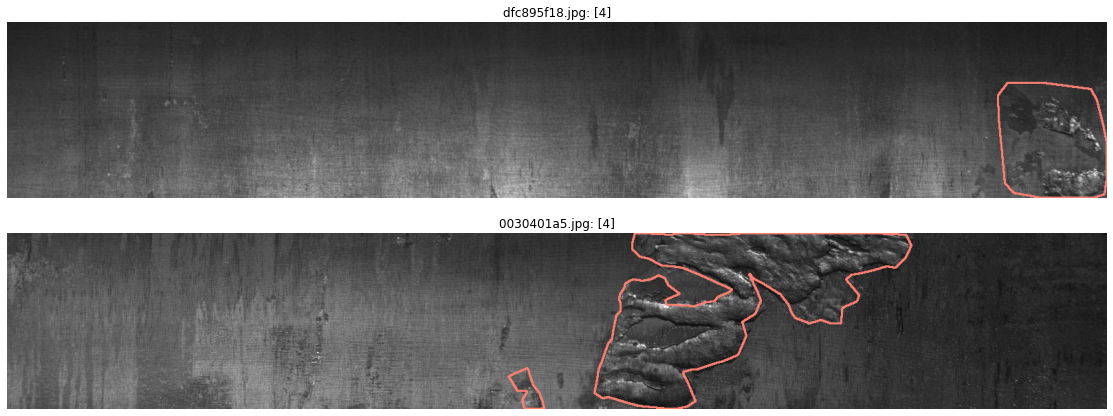

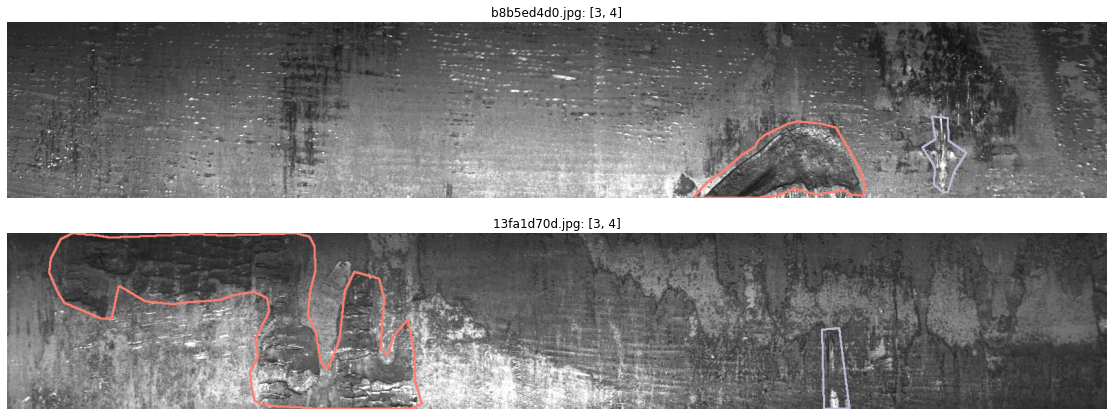

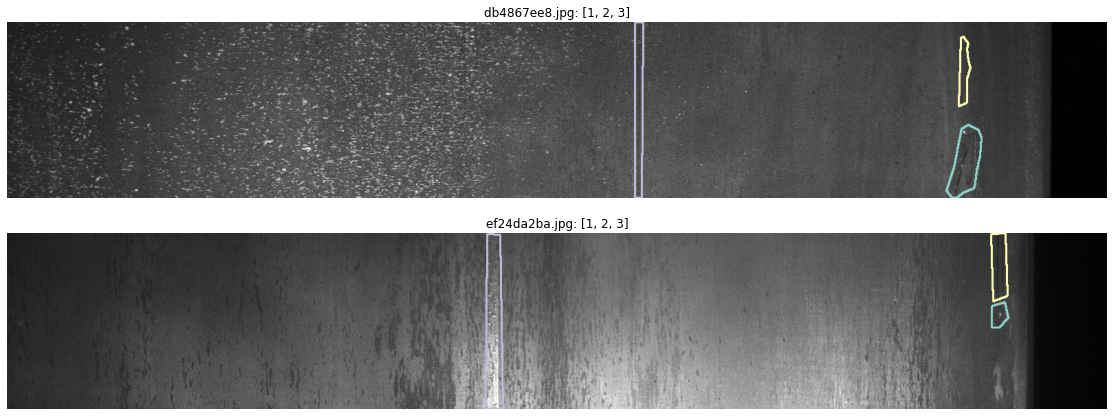

In [17]:
# the images we want to see
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]',
    squashed['DistinctDefectTypes']==2,
    squashed['DistinctDefectTypes']==3
]

sample_size = 2

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size)     
    # make a subplot
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        ax = axes[i,]
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)
        image = visualise_mask(file_name=row.ImageId, mask=mask)
        
        ax.set_title(f'{row.ImageId}: {row.ClassId}')
        ax.axis('off')
        ax.imshow(image);

<a id="5"></a> <br>
# Semantic Segmentation
Given below is an example of semantic segmentation:
![semantic_segmentation](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-7.42.16-PM.png)

The goal of semantic segmentation is to predict the class label of each pixel in the image.
Note that we're not separating instances of the same class, we only care about the category of each pixel.


## Our network (Unet)

U-net is a convolutional neural network that was developed for biomedical image segmentation. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 1600 × 256 image takes less than a second on a modern GPU.

![](https://imgur.com/LFiHQnl.png)

The encoder architecture that we are using is based off resnet18 and the network has been pre-trained on ImageNet.

In [23]:
from segmentation_models_pytorch import Unet
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

from torchsummary import summary
summary(model.cuda(), input_size=(3, 256, 1600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 800]           9,408
       BatchNorm2d-2         [-1, 64, 128, 800]             128
              ReLU-3         [-1, 64, 128, 800]               0
         MaxPool2d-4          [-1, 64, 64, 400]               0
            Conv2d-5          [-1, 64, 64, 400]          36,864
       BatchNorm2d-6          [-1, 64, 64, 400]             128
              ReLU-7          [-1, 64, 64, 400]               0
            Conv2d-8          [-1, 64, 64, 400]          36,864
       BatchNorm2d-9          [-1, 64, 64, 400]             128
             ReLU-10          [-1, 64, 64, 400]               0
       BasicBlock-11          [-1, 64, 64, 400]               0
           Conv2d-12          [-1, 64, 64, 400]          36,864
      BatchNorm2d-13          [-1, 64, 64, 400]             128
             ReLU-14          [-1, 64, 